In [14]:
import pandas as pd
import numpy as np
from datetime import datetime

# === File paths ===
INPUT_CSV = "downloads/all_companies_with_sectors_corrected.csv"
OUTPUT_CSV = "downloads/marketcap_summary_2024.csv"
YEAR = 2024
YEAR_END = pd.to_datetime(f"{YEAR}-12-31")

# === Company list ===
companies = [
    ("3436 JP Equity", "SUMCO Corp", "Silicon wafer manufacturer"),
    ("4063 JP Equity", "Shin-Etsu Chemical", "Global leader in silicon wafers"),
    ("4185 JP Equity", "JSR Corp", "Photoresists and chemical materials"),
    ("8035 JP Equity", "Tokyo Electron (TEL)", "Semiconductor equipment manufacturer"),
    ("AMAT US Equity", "Applied Materials", "Leading wafer fabrication equipment supplier"),
    ("ASML NA Equity", "ASML Holding", "Exclusive lithography equipment supplier"),
    ("CDNS US Equity", "Cadence Design Systems", "EDA software provider"),
    ("KLAC US Equity", "KLA Corp", "Process inspection and metrology tools"),
    ("LRCX US Equity", "Lam Research", "Etching and cleaning equipment"),
    ("SNPS US Equity", "Synopsys", "EDA tools and IP provider"),
    ("005930 KS Equity", "Samsung Electronics", "IDM with both chip manufacturing & devices"),
    ("2330 TT Equity", "TSMC", "World’s largest foundry"),
    ("GFS US Equity", "GlobalFoundries", "Foundry services"),
    ("INTC US Equity", "Intel", "IDM"),
    ("MU US Equity", "Micron Technology", "Memory IDM"),
    ("TXN US Equity", "Texas Instruments", "Analog and embedded IDM"),
    ("2454 TT Equity", "MediaTek", "Mobile SoCs"),
    ("AMD US Equity", "Advanced Micro Devices", "CPUs and GPUs"),
    ("AVGO US Equity", "Broadcom", "Network and RF chips"),
    ("NVDA US Equity", "NVIDIA", "GPUs and AI processors"),
    ("QCOM US Equity", "Qualcomm", "Mobile and communication chips"),
    ("3711 TT Equity", "ASE Technology", "World’s largest OSAT provider"),
    ("AMKR US Equity", "Amkor Technology", "Major packaging and testing firm"),
    ("IFX GR Equity", "Infineon Technologies", "Leader in automotive semiconductors"),
    ("NXPI US Equity", "NXP Semiconductors", "MCU and connectivity chips for vehicles"),
    ("AMZN US Equity", "Amazon", "AWS cloud and AI services"),
    ("MSFT US Equity", "Microsoft", "Azure cloud and AI integration"),
    ("GOOG US Equity", "Alphabet (Google)", "Cloud & AI ecosystems"),
    ("META US Equity", "Meta Platforms", "AI and social applications"),
    ("CRM US Equity", "Salesforce", "Cloud-based enterprise software"),
    ("ORCL US Equity", "Oracle", "Cloud database and infrastructure"),
    ("IBM US Equity", "IBM", "AI & hybrid cloud services"),
    ("PLTR US Equity", "Palantir", "AI-driven data analytics"),
    ("HPE US Equity", "Hewlett Packard Enterprise", "Cloud infrastructure"),
    ("DELL US Equity", "Dell Technologies", "Cloud and enterprise hardware"),
    ("BIDU US Equity", "Baidu", "AI and cloud services"),
    ("6758 JP Equity", "Sony Group", "Consumer electronics"),
    ("AAPL US Equity", "Apple", "Consumer devices and ecosystems"),
    ("7203 JP Equity", "Toyota Motor", "Automotive OEM"),
    ("BMW GR Equity", "BMW Group", "Automotive OEM"),
    ("F US Equity", "Ford Motor", "Automotive OEM"),
    ("GM US Equity", "General Motors", "Automotive OEM"),
    ("MBG GR Equity", "Mercedes-Benz Group", "Automotive OEM"),
    ("VOW GR Equity", "Volkswagen Group", "Automotive OEM"),
    ("1211 HK Equity", "BYD Co Ltd", "Chinese EV leader"),
    ("NIO US Equity", "NIO Inc", "Chinese EV startup"),
    ("TSLA US Equity", "Tesla Inc", "Global EV leader"),
]

# === Load data ===
df = pd.read_csv(INPUT_CSV, low_memory=False)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["CUR_MKT_CAP"] = pd.to_numeric(df["CUR_MKT_CAP"], errors="coerce")

# Detect column that stores ticker text
key_col = next((c for c in ["company_sheet", "ticker", "RIC", "symbol", "Ticker"] if c in df.columns), None)
if key_col is None:
    print("Warning: No ticker column found; matching by text search across all columns.")

# === Function to get rows for ticker ===
def find_rows(ticker):
    base = ticker.split()[0]
    if key_col:
        mask = df[key_col].astype(str).str.contains(base, case=False, na=False) | \
               df[key_col].astype(str).str.contains(ticker, case=False, na=False)
        return df[mask].copy()
    else:
        return df[df.astype(str).apply(lambda r: r.str.contains(base, case=False, na=False).any(), axis=1)].copy()

# === Compute results ===
rows_out = []
for ticker, name, desc in companies:
    rows = find_rows(ticker)
    rows_2024 = rows[rows["Date"].dt.year == YEAR].copy()
    avg_mc = np.nan
    yearend_mc = np.nan
    yearend_date = pd.NaT
    if not rows_2024.empty:
        mc = rows_2024["CUR_MKT_CAP"].dropna()
        if not mc.empty:
            avg_mc = mc.mean()
            rows_2024["absdiff"] = (rows_2024["Date"] - YEAR_END).abs()
            closest = rows_2024.loc[rows_2024["absdiff"].idxmin()]
            yearend_mc = closest["CUR_MKT_CAP"]
            yearend_date = closest["Date"]
    rows_out.append({
        "ticker": ticker,
        "company_name": name,
        "description": desc,
        "avg_market_cap_2024": avg_mc,
        "yearend_market_cap_closest_2024": yearend_mc,
        "yearend_date": yearend_date
    })

out = pd.DataFrame(rows_out)

# Format numbers and export
out["avg_market_cap_2024"] = out["avg_market_cap_2024"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "")
out["yearend_market_cap_closest_2024"] = out["yearend_market_cap_closest_2024"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "")
out["yearend_date"] = out["yearend_date"].astype(str).replace("NaT", "")

out.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Market-cap summary saved to: {OUTPUT_CSV}")
print(out.head(10))



✅ Market-cap summary saved to: downloads/marketcap_summary_2024.csv
           ticker            company_name  \
0  3436 JP Equity              SUMCO Corp   
1  4063 JP Equity      Shin-Etsu Chemical   
2  4185 JP Equity                JSR Corp   
3  8035 JP Equity    Tokyo Electron (TEL)   
4  AMAT US Equity       Applied Materials   
5  ASML NA Equity            ASML Holding   
6  CDNS US Equity  Cadence Design Systems   
7  KLAC US Equity                KLA Corp   
8  LRCX US Equity            Lam Research   
9  SNPS US Equity                Synopsys   

                                    description avg_market_cap_2024  \
0                    Silicon wafer manufacturer                   0   
1               Global leader in silicon wafers                   0   
2           Photoresists and chemical materials                   0   
3          Semiconductor equipment manufacturer                   0   
4  Leading wafer fabrication equipment supplier             158,145   
5      Ex

In [15]:
import pandas as pd
import numpy as np

# === Input / Output ===
INPUT_XLS = "downloads/marketcap_summary_2024.xlsx"  
OUTPUT_XLS = "downloads/marketcap_summary_2024_usd.xlsx"

# === 2024 fx rate USD ===
fx_rate = {
    "USD": 1.0,
    "TWD": 31.6,
    "JPY": 145.0,
    "EUR": 0.92,
    "HKD": 7.82,
    "KRW": 1340.0
}

# === ticker ===
def detect_currency(ticker):
    t = str(ticker)
    if "US" in t:
        return "USD"
    elif "TT" in t:   # Taiwan
        return "TWD"
    elif "JP" in t:   # Japan
        return "JPY"
    elif "GR" in t:   # Germany / EUR
        return "EUR"
    elif "HK" in t:   # Hong Kong
        return "HKD"
    elif "KS" in t:   # Korea (you used KS earlier)
        return "KRW"
    else:
        return "USD"

# === read Excel ===
# If file has multiple sheets and the table is in the first sheet, read_excel will pick it up.
df = pd.read_excel(INPUT_XLS)

# === clean data ===
def to_num_maybe(x):
    if pd.isna(x):
        return np.nan
    # remove commas and spaces
    s = str(x).replace(",", "").strip()
    try:
        return float(s)
    except:
        return np.nan

for col in ["avg_market_cap_2024", "yearend_market_cap_closest_2024"]:
    if col in df.columns:
        df[col] = df[col].apply(to_num_maybe)
    else:
        raise KeyError(f"Column '{col}' not found in {INPUT_XLS} - please check column names.")

# === map currency and fx rate ===
df["currency"] = df["ticker"].astype(str).apply(detect_currency)
df["fx_rate_to_usd"] = df["currency"].map(fx_rate)

# === transfer ===
df["avg_market_cap_2024_usd_million"] = df["avg_market_cap_2024"] / df["fx_rate_to_usd"]
df["yearend_market_cap_closest_2024_usd_million"] = df["yearend_market_cap_closest_2024"] / df["fx_rate_to_usd"]

df["avg_market_cap_2024_usd_full"] = df["avg_market_cap_2024_usd_million"] * 1_000_000
df["yearend_market_cap_closest_2024_usd_full"] = df["yearend_market_cap_closest_2024_usd_million"] * 1_000_000

# output Excel
try:
    df.to_excel(OUTPUT_XLS, index=False)
    print(f"✅ Converted file saved to: {OUTPUT_XLS}")
except Exception as e:
    # fallback to xlsx if xls fails
    alt = OUTPUT_XLS.replace(".xls", ".xlsx")
    df.to_excel(alt, index=False)
    print(f"⚠️ Saving to .xls failed, saved to: {alt}. Error: {e}")

# print preview
cols_preview = [
    "ticker", "company_name", "currency", "fx_rate_to_usd",
    "avg_market_cap_2024", "avg_market_cap_2024_usd_million", "avg_market_cap_2024_usd_full",
    "yearend_market_cap_closest_2024", "yearend_market_cap_closest_2024_usd_million", "yearend_market_cap_closest_2024_usd_full",
    "yearend_date"
]
print(df[cols_preview].head(20).to_string(index=False))


✅ Converted file saved to: downloads/marketcap_summary_2024_usd.xlsx
          ticker           company_name currency  fx_rate_to_usd  avg_market_cap_2024  avg_market_cap_2024_usd_million  avg_market_cap_2024_usd_full  yearend_market_cap_closest_2024  yearend_market_cap_closest_2024_usd_million  yearend_market_cap_closest_2024_usd_full yearend_date
  3436 JP Equity             SUMCO Corp      JPY           145.0         6.519820e+02                     4.496428e+00                  4.496428e+06                     4.142570e+02                                 2.856945e+00                              2.856945e+06   2024-12-31
  4063 JP Equity     Shin-Etsu Chemical      JPY           145.0         1.203558e+07                     8.300403e+04                  8.300403e+10                     1.051254e+07                                 7.250026e+04                              7.250026e+10   2024-12-31
  8035 JP Equity   Tokyo Electron (TEL)      JPY           145.0         1.461413e+07

In [11]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


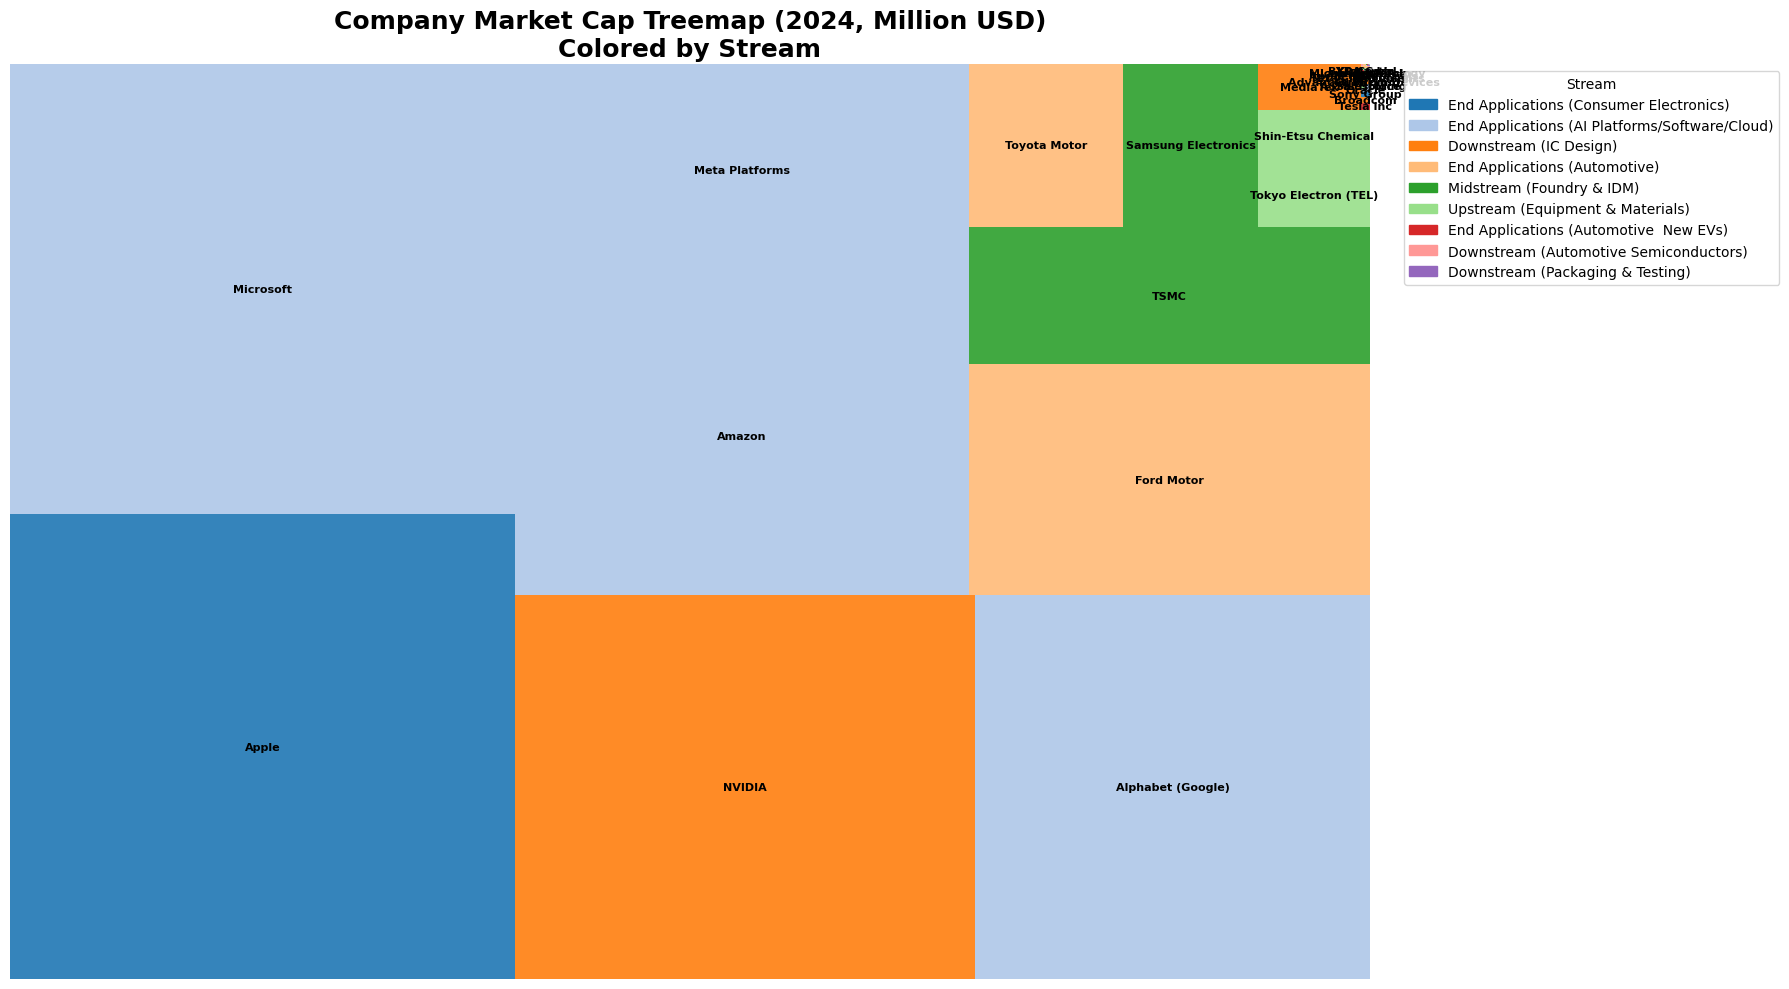

✅ Treemap：/Users/min/downloads/treemap_marketcap_2024_usd.png


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify


INPUT_XLSX = "downloads/marketcap_summary_2024_usd.xlsx"
OUTPUT_PNG = "downloads/treemap_marketcap_2024_usd.png"

# read 
df = pd.read_excel(INPUT_XLSX, engine="openpyxl")

# check the columns
required_cols = ["company_name", "stream", "avg_market_cap_2024_usd_million"]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"Column '{c}' not found. Available columns: {df.columns.tolist()}")

# remove market value <= 0 or missing data
df = df.dropna(subset=["avg_market_cap_2024_usd_million", "stream", "company_name"])
df = df[df["avg_market_cap_2024_usd_million"] > 0].copy()

# market value sorting
df = df.sort_values("avg_market_cap_2024_usd_million", ascending=False).reset_index(drop=True)

# === stream color ===
streams = df["stream"].unique()
cmap = plt.get_cmap("tab20")
color_map = {s: cmap(i % 20) for i, s in enumerate(streams)}
df["color"] = df["stream"].map(color_map)

# === label ===
df["label"] = df.apply(lambda r: r["company_name"] if r.name < 30 else "", axis=1)

# === Treemap ===
plt.figure(figsize=(18, 10))
squarify.plot(
    sizes=df["avg_market_cap_2024_usd_million"],
    label=df["label"],
    color=df["color"],
    alpha=0.9,
    text_kwargs={"fontsize": 8, "weight": "bold"}
)

plt.axis("off")
plt.title("Company Market Cap Treemap (2024, Million USD)\nColored by Stream", fontsize=18, weight="bold")

# === chart ===
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[s]) for s in streams]
plt.legend(handles, streams, title="Stream", bbox_to_anchor=(1.02, 1), loc="upper left")

# === save files ===
plt.tight_layout()
plt.savefig(OUTPUT_PNG, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Treemap：{os.path.abspath(OUTPUT_PNG)}")
